In [38]:
!git clone https://github.com/swordmanager/sentiment_analysis_nal.git

Cloning into 'sentiment_analysis_nal'...
remote: Enumerating objects: 33, done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 33
Unpacking objects: 100% (33/33), done.


In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re 
from collections import Counter 
import nltk 
from tqdm.notebook import tqdm 
from pyvi import ViTokenizer
import os

def load_file(filepath, name_string):
    with open(filepath, 'r') as f:
        doc = f.read()
    sentences = []
    labels = []
    for line in doc.split('\n'):
        if name_string in line:
            isopen = True
            sentences.append("")
            if name_string == "test_":
                sentences[-1] = re.sub('\s+', ' ', sentences[-1].strip()[1:-1].strip())
                labels.append(line)
            continue
        if (line == "0" or line == "1") and isopen:
            sentences[-1] = re.sub('\s+', ' ', sentences[-1].strip()[1:-1].strip())
            labels.append(int(line))
            isopen = False
        else:
            sentences[-1] += line 
    return sentences, labels

train_sentences, train_labels = load_file('/kaggle/working/sentiment_analysis_nal/data_clean/train.crash', name_string='train_')
test_sentences, test_labels = load_file('/kaggle/working/sentiment_analysis_nal/data_clean/test.crash', name_string='test_')

In [55]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'([a-z])\1+', lambda m: m.group(1), text)
    replace_list = {
        'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ', 'òe': 'oè', 'óe': 'oé','ỏe': 'oẻ',
        'õe': 'oẽ', 'ọe': 'oẹ', 'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ','ụy': 'uỵ', 'uả': 'ủa',
        'ả': 'ả', 'ố': 'ố', 'u´': 'ố','ỗ': 'ỗ', 'ồ': 'ồ', 'ổ': 'ổ', 'ấ': 'ấ', 'ẫ': 'ẫ', 'ẩ': 'ẩ',
        'ầ': 'ầ', 'ỏ': 'ỏ', 'ề': 'ề','ễ': 'ễ', 'ắ': 'ắ', 'ủ': 'ủ', 'ế': 'ế', 'ở': 'ở', 'ỉ': 'ỉ',
        'ẻ': 'ẻ', 'àk': u' à ','aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ','ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á',
        #Quy các icon về 2 loại emoj: Tích cực hoặc tiêu cực
        "👹": "nagative", "👻": "positive", "💃": "positive",'🤙': ' positive ', '👍': ' positive ',
        "💄": "positive", "💎": "positive", "💩": "positive","😕": "nagative", "😱": "nagative", "😸": "positive",
        "😾": "nagative", "🚫": "nagative",  "🤬": "nagative","🧚": "positive", "🧡": "positive",'🐶':' positive ',
        '👎': ' nagative ', '😣': ' nagative ','✨': ' positive ', '❣': ' positive ','☀': ' positive ',
        '♥': ' positive ', '🤩': ' positive ', 'like': ' positive ', '💌': ' positive ',
        '🤣': ' positive ', '🖤': ' positive ', '🤤': ' positive ', ':(': ' nagative ', '😢': ' nagative ',
        '❤': ' positive ', '😍': ' positive ', '😘': ' positive ', '😪': ' nagative ', '😊': ' positive ',
        '?': ' ? ', '😁': ' positive ', '💖': ' positive ', '😟': ' nagative ', '😭': ' nagative ',
        '💯': ' positive ', '💗': ' positive ', '♡': ' positive ', '💜': ' positive ', '🤗': ' positive ',
        '^^': ' positive ', '😨': ' nagative ', '☺': ' positive ', '💋': ' positive ', '👌': ' positive ',
        '😖': ' nagative ', '😀': ' positive ', ':((': ' nagative ', '😡': ' nagative ', '😠': ' nagative ',
        '😒': ' nagative ', '🙂': ' positive ', '😏': ' nagative ', '😝': ' positive ', '😄': ' positive ',
        '😙': ' positive ', '😤': ' nagative ', '😎': ' positive ', '😆': ' positive ', '💚': ' positive ',
        '✌': ' positive ', '💕': ' positive ', '😞': ' nagative ', '😓': ' nagative ', '️🆗️': ' positive ',
        '😉': ' positive ', '😂': ' positive ', ':v': '  positive ', '=))': '  positive ', '😋': ' positive ',
        '💓': ' positive ', '😐': ' nagative ', ':3': ' positive ', '😫': ' nagative ', '😥': ' nagative ',
        '😃': ' positive ', '😬': ' 😬 ', '😌': ' 😌 ', '💛': ' positive ', '🤝': ' positive ', '🎈': ' positive ',
        '😗': ' positive ', '🤔': ' nagative ', '😑': ' nagative ', '🔥': ' nagative ', '🙏': ' nagative ',
        '🆗': ' positive ', '😻': ' positive ', '💙': ' positive ', '💟': ' positive ',
        '😚': ' positive ', '❌': ' nagative ', '👏': ' positive ', ';)': ' positive ', '<3': ' positive ',
        '🌝': ' positive ',  '🌷': ' positive ', '🌸': ' positive ', '🌺': ' positive ',
        '🌼': ' positive ', '🍓': ' positive ', '🐅': ' positive ', '🐾': ' positive ', '👉': ' positive ',
        '💐': ' positive ', '💞': ' positive ', '💥': ' positive ', '💪': ' positive ',
        '💰': ' positive ',  '😇': ' positive ', '😛': ' positive ', '😜': ' positive ',
        '🙃': ' positive ', '🤑': ' positive ', '🤪': ' positive ','☹': ' nagative ',  '💀': ' nagative ',
        '😔': ' nagative ', '😧': ' nagative ', '😩': ' nagative ', '😰': ' nagative ', '😳': ' nagative ',
        '😵': ' nagative ', '😶': ' nagative ', '🙁': ' nagative ',
        #Chuẩn hóa 1 số sentiment words/English words
        ':))': '  positive ', ':)': ' positive ', 'ô kêi': ' ok ', 'okie': ' ok ', ' o kê ': ' ok ',
        'okey': ' ok ', 'ôkê': ' ok ', 'oki': ' ok ', ' oke ':  ' ok ',' okay':' ok ','okê':' ok ',
        ' tks ': u' cám ơn ', 'thks': u' cám ơn ', 'thanks': u' cám ơn ', 'ths': u' cám ơn ', 'thank': u' cám ơn ',
        '⭐': 'star ', '*': 'star ', '🌟': 'star ', '🎉': u' positive ',
        'kg ': u' không ','not': u' không ', u' kg ': u' không ', '"k ': u' không ',' kh ':u' không ','kô':u' không ','hok':u' không ',' kp ': u' không phải ',u' kô ': u' không ', '"ko ': u' không ', u' ko ': u' không ', u' k ': u' không ', 'khong': u' không ', u' hok ': u' không ',
        'he he': ' positive ','hehe': ' positive ','hihi': ' positive ', 'haha': ' positive ', 'hjhj': ' positive ',
        ' lol ': ' nagative ',' cc ': ' nagative ','cute': u' dễ thương ','huhu': ' nagative ', ' vs ': u' với ', 'wa': ' quá ', 'wá': u' quá', 'j': u' gì ', '“': ' ',
        ' sz ': u' cỡ ', 'size': u' cỡ ', u' đx ': u' được ', 'dk': u' được ', 'dc': u' được ', 'đk': u' được ',
        'đc': u' được ','authentic': u' chuẩn chính hãng ',u' aut ': u' chuẩn chính hãng ', u' auth ': u' chuẩn chính hãng ', 'thick': u' positive ', 'store': u' cửa hàng ',
        'shop': u' cửa hàng ', 'sp': u' sản phẩm ', 'gud': u' tốt ','god': u' tốt ','wel done':' tốt ', 'good': u' tốt ', 'gút': u' tốt ',
        'sấu': u' xấu ','gut': u' tốt ', u' tot ': u' tốt ', u' nice ': u' tốt ', 'perfect': 'rất tốt', 'bt': u' bình thường ',
        'time': u' thời gian ', 'qá': u' quá ', u' ship ': u' giao hàng ', u' m ': u' mình ', u' mik ': u' mình ',
        'ể': 'ể', 'product': 'sản phẩm', 'quality': 'chất lượng','chat':' chất ', 'excelent': 'hoàn hảo', 'bad': 'tệ','fresh': ' tươi ','sad': ' tệ ',
        'date': u' hạn sử dụng ', 'hsd': u' hạn sử dụng ','quickly': u' nhanh ', 'quick': u' nhanh ','fast': u' nhanh ','delivery': u' giao hàng ',u' síp ': u' giao hàng ',
        'beautiful': u' đẹp tuyệt vời ', u' tl ': u' trả lời ', u' r ': u' rồi ', u' shopE ': u' cửa hàng ',u' order ': u' đặt hàng ',
        'chất lg': u' chất lượng ',u' sd ': u' sử dụng ',u' dt ': u' điện thoại ',u' nt ': u' nhắn tin ',u' tl ': u' trả lời ',u' sài ': u' xài ',u'bjo':u' bao giờ ',
        'thik': u' thích ',u' sop ': u' cửa hàng ', ' fb ': ' facebook ', ' face ': ' facebook ', ' very ': u' rất ',u' quả ng ':u' quảng  ',
        'dep': u' đẹp ',u' xau ': u' xấu ','delicious': u' ngon ', u'hàg': u' hàng ', u'qủa': u' quả ',
        'iu': u' yêu ','fake': u' giả mạo ', 'trl': 'trả lời', '><': u' positive ',
        ' por ': u' tệ ',' poor ': u' tệ ', ' ib ':u' nhắn tin ', ' rep ':u' trả lời ',u' fback ':' feedback ',' fedback ':' feedback ',
        #dưới 3* quy về 1*, trên 3* quy về 5*
        ' 6 sao ': ' 5star ',' 6 star ': ' 5star ', ' 5star ': ' 5star ',' 5 sao ': ' 5star ',' 5sao ': ' 5star ',
        ' starstarstarstarstar ': ' 5star ', ' 1 sao ': ' 1star ', ' 1sao ': ' 1star ', ' 2 sao ':' 1star ',' 2sao ':' 1star ',
        ' 2 starstar ':' 1star ',' 1star ': ' 1star ', ' 0 sao ': ' 1star ', ' 0star ': ' 1star ',}
    for k, v in replace_list.items():
        text = text.replace(k, v)
    
    text = ViTokenizer.tokenize(text)
    text = text.split()
    text = u' '.join(text)
    
    return text

train_sentences = [normalize_text(text) for text in tqdm(train_sentences)]
test_sentences = [normalize_text(text) for text in tqdm(test_sentences)]

In [2]:
!pip install pyvi

     |████████████████████████████████| 8.7 MB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 743 kB 53.3 MB/s eta 0:00:01


In [57]:
if hasattr(tqdm, '_instance'): tqdm._instance.clear()

words = Counter()
for i, sentence in tqdm(enumerate(train_sentences)):
    train_sentences[i] = []
#     sentence = ViTokenizer.tokenize(sentence)
    for w in nltk.word_tokenize(sentence):
        words.update([w.lower()])
        train_sentences[i].append(w.lower())

In [22]:
from gensim.models import KeyedVectors

model = '/kaggle/input/kpdl-data/baomoi.model.bin'
word2vec_model = KeyedVectors.load_word2vec_format(model, binary=True)

In [58]:
words = {w:c for w,c in words.items() if c>1}
words = sorted(words, key=words.get, reverse=True)
words = ['_PAD', '_UNK'] + words

In [59]:
word2int = {w:i for i,w in enumerate(words)}
int2word = {i:w for i,w in enumerate(words)}

In [60]:
import numpy as np 

embed_size = 400
embed_matrix = np.zeros((len(words), embed_size))
count = 0
not_in_word = []
for i, w in enumerate(words):
    try:
        vector = word2vec_model.get_vector(w)
        embed_matrix[i] = vector
    except KeyError:
        count += 1
        embed_matrix[i] = np.random.normal(scale=0.6, size=(embed_size, ))

In [61]:
for i, sentence in tqdm(enumerate(train_sentences)):
    train_sentences[i] = [word2int[w] if w in word2int else 1 for w in sentence]

In [62]:
for i,sentence in enumerate(test_sentences):
    test_sentences[i] = [word2int[w.lower()] if w.lower() in word2int else 1 for w in nltk.word_tokenize(sentence)]

In [63]:
def pad_sequence(sentences, seq_length):
    features = np.zeros((len(sentences), seq_length), dtype=int)
    for i, sentence in enumerate(sentences):
        if len(sentence)!=0:
            features[i, -len(sentence):] = np.array(sentence)[:seq_length]
    return features

In [64]:
seq_length = 200
train_sentences = pad_sequence(train_sentences, seq_length)
test_sentences = pad_sequence(test_sentences, seq_length)

In [65]:
train_labels = np.array(train_labels)
val_split = int(0.2*len(train_sentences))
validation_sentences, validation_labels = train_sentences[:val_split], train_labels[:val_split]
train_sentences, train_labels = train_sentences[val_split:], train_labels[val_split:]

In [66]:
from torch.utils.data import TensorDataset, DataLoader
import torch 

traindata = TensorDataset(torch.from_numpy(train_sentences), torch.from_numpy(train_labels))
valdata = TensorDataset(torch.from_numpy(validation_sentences), torch.from_numpy(validation_labels))
batch_size = 400
trainloader = DataLoader(traindata, shuffle=True, batch_size=batch_size)
valloader = DataLoader(valdata, shuffle=True, batch_size=batch_size)

In [75]:
import torch.nn as nn 
import torch.nn.functional as F

class SentimentNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.Embedding = nn.Embedding(vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=0.3, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, h):
        batch_size = x.shape[0]
        x = self.Embedding(x)
        x, h = self.LSTM(x, h)
        x = x.contiguous().view(-1, self.hidden_dim)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        x = x.view(batch_size, -1)
        x = x[:, -1]
        return x, h
    
    def init_hidden(self, batch_size):
        weights = next(self.parameters()).data
        hidden = (weights.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                 weights.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden
        
vocab_size = len(word2int)
embedding_dim = 400
hidden_dim = 512
n_layers = 2 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SentimentNet(vocab_size, embedding_dim, hidden_dim, n_layers).to(device)

In [83]:
# model.Embedding.weight = nn.Parameter(torch.from_numpy(embed_matrix).float()).to(device)
model.Embedding.weight.data.copy_(torch.from_numpy(embed_matrix))
model.Embedding.weight.requires_grad = False

In [77]:
########## TRAINING SESSION ###############
import torch.optim as optim 
from tqdm.notebook import tqdm as tqdm


def get_full_batch_size(X, y, batch_size):
    while len(y) < batch_size:
        X = np.concatenate((X, X), axis=0)
        y = np.concatenate((y, y), axis=0)
    X = torch.from_numpy(X[:batch_size])
    y = torch.from_numpy(y[:batch_size])
    return X, y 

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)
epochs = 5
batch_size = 400

clip = 5
print_every = 100
h = model.init_hidden(batch_size)
count = 0
model.train()
losses = []
val_min = np.Inf
for epoch in range(epochs):
    training_loss = 0
#     if hasattr(tqdm, '_instance'): tqdm._instance.clear()
    for X, y in tqdm(trainloader):
        if hasattr(tqdm, '_instance'): tqdm._instance.clear()
        if len(y) != batch_size:
            X, y = get_full_batch_size(X, y, batch_size)
        optimizer.zero_grad()
        h = tuple([e.data for e in h])
        X, y = X.to(device), y.to(device)
        out, h = model(X, h)
        loss = criterion(out, y.float())
        training_loss += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        count += 1
    else:
        

        model.eval()
        val_h = model.init_hidden(batch_size)
        val_loss = 0 
        acc = 0
        for X, y in tqdm(valloader):
            if len(y) != batch_size:
                X, y = get_full_batch_size(X, y, batch_size)
            val_h = tuple([e.data for e in val_h])
            X, y = X.to(device), y.to(device)
            out, val_h = model(X, val_h)
            loss = criterion(out, y.float())
            val_loss += loss.item()
            pred = torch.round(out)
            equal = (y == pred)
            acc += torch.mean(equal.float())

        training_loss /= len(trainloader)
        val_loss /= len(valloader)
        print("\nEPOCH %d/%d ..." %(epoch+1, epochs))
        print("Training loss : %.4f" %(training_loss))
        print("Validation loss : %.4f" %(val_loss))
        print("Validation accuracy : %.2f" %(acc/len(valloader)))
        if val_loss < val_min:
            print("Validation loss decrease {:.4f} ---> {:.4f}".format(val_min, val_loss))
            val_min = val_loss
            print("Save weights ...")
            torch.save(model.state_dict(), 'model.h5')
        losses.append([training_loss, val_loss])
        model.train()

        



EPOCH 1/5 ...
Training loss : 0.4064
Validation loss : 0.2590
Validation accuracy : 0.90
Validation loss decrease inf ---> 0.2590
Save weights ...




EPOCH 2/5 ...
Training loss : 0.2303
Validation loss : 0.1871
Validation accuracy : 0.93
Validation loss decrease 0.2590 ---> 0.1871
Save weights ...




EPOCH 3/5 ...
Training loss : 0.1735
Validation loss : 0.1865
Validation accuracy : 0.93
Validation loss decrease 0.1871 ---> 0.1865
Save weights ...




EPOCH 4/5 ...
Training loss : 0.1481
Validation loss : 0.2030
Validation accuracy : 0.93




EPOCH 5/5 ...
Training loss : 0.1147
Validation loss : 0.1450
Validation accuracy : 0.94
Validation loss decrease 0.1865 ---> 0.1450
Save weights ...


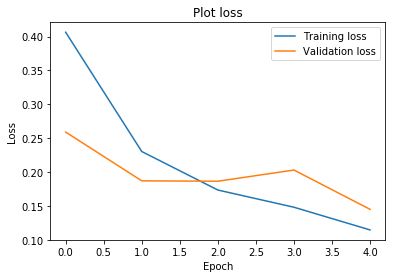

In [78]:
import matplotlib.pyplot as plt 
%matplotlib inline 

losses = np.array(losses)
plt.plot(losses.T[0], label = 'Training loss')
plt.plot(losses.T[1], label = 'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Plot loss')
plt.legend()

In [79]:
model.load_state_dict(torch.load('/kaggle/working/model.h5'))

<All keys matched successfully>

In [80]:
batch_size = 1 
tmp = np.zeros(len(test_sentences))
testdata = TensorDataset(torch.from_numpy(test_sentences), torch.from_numpy(tmp))
testloader = DataLoader(testdata, batch_size=batch_size)

In [81]:
model.eval()
batch_size = 1 
val_h = model.init_hidden(batch_size)
val_loss = 0 
pred = []
for X, _ in tqdm(testloader):
    val_h = tuple([e.data for e in val_h])
    X = X.to(device)
    out, val_h = model(X, val_h)
    pred.append(int(torch.round(out).item()))

In [82]:
import pandas as pd 
dict = {'id':test_labels, 'label':pred}
df = pd.DataFrame(dict)
df.to_csv('output.csv', index=False)